In [1]:
'E:/ZIP-DeepAR代码/data/InterSim层次聚类后的Q料202001-202302(halfmonth).csv'

'E:/ZIP-DeepAR代码/data/InterSim层次聚类后的Q料202001-202302(halfmonth).csv'


===== 全局评估指标 =====
RMSE: 4.1448
MAE: 1.6326

===== 非零值评估指标 =====
非零值RMSE: 5.9317
非零值MAE: 3.3436
非零值MASE: 3.8641
非零值RMSSE: 1.7129

===== 零值评估指标 =====
零值准确率: 100.00%
零值精确率: 0.5117
零值召回率: 1.0000
零值F1分数: 0.6770

MASE: 1.8867
RMSSE: 0.8364

===== QuantileLoss指标 =====
L=0, S=1, q=0.5时的QuantileLoss值：0.9997

===== 分段指标 =====
0 MAE: 0.0002
0-50 MAE: 3.2562
50-100 MAE: 65.1095
100+ MAE: 129.8900

===== 结果已保存到: SBJm5.csv =====


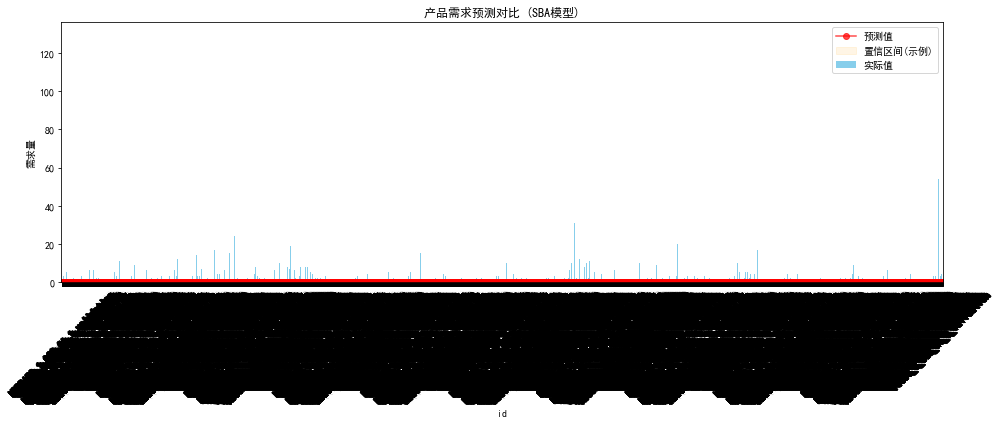

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def optimized_sbj(series, alpha=0.2):
    """优化后的SBJ单步预测函数"""
    series = np.array(series)
    nonzero = series[series > 0]
    
    if len(nonzero) == 0:
        return 0.0
    
    q = nonzero[0] if len(nonzero) > 0 else 0.0
    a = 1.0 if len(nonzero) > 0 else 0.0
    
    for i in range(1, len(series)):
        if series[i] > 0:
            a = alpha * (i - a) + (1 - alpha) * a
            q = alpha * series[i] + (1 - alpha) * q
    
    forecast = (1 - alpha/(2-alpha) )* (q / a) if a != 0 else 0.0
                
    return max(0.0, round(forecast, 2))

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """支持标量输入的MASE计算"""
    y_true = np.atleast_1d(y_true)
    y_pred = np.atleast_1d(y_pred)
    y_train = np.asarray(y_train)
    
    if len(y_train) < 2 or len(y_true) == 0:
        return np.nan
    
    scaling_factor = np.mean(np.abs(np.diff(y_train)))
    if scaling_factor == 0:
        return np.nan
    
    return np.mean(np.abs(y_true - y_pred)) / scaling_factor

def root_mean_square_scaled_error(y_true, y_pred, y_train):
    """支持标量输入的RMSSE计算"""
    y_true = np.atleast_1d(y_true)
    y_pred = np.atleast_1d(y_pred)
    y_train = np.asarray(y_train)
    
    if len(y_train) < 2 or len(y_true) == 0:
        return np.nan
    
    scaling_factor = np.mean(np.square(np.diff(y_train)))
    if scaling_factor == 0:
        return np.nan
    
    return np.sqrt(np.mean(np.square(y_true - y_pred)) / scaling_factor)

def Segment_MAE(test_y, test_predict):
    """分段MAE计算"""
    test_y = np.array(test_y)
    test_predict = np.array(test_predict)
    
    segments = {
        '0': (test_y == 0),
        '0-50': (test_y > 0) & (test_y <= 50),
        '50-100': (test_y > 50) & (test_y <= 100),
        '100+': (test_y > 100)
    }
    
    for name, mask in segments.items():
        y_segment = test_y[mask]
        pred_segment = test_predict[mask]
        if len(y_segment) > 0:
            mae = mean_absolute_error(y_segment, pred_segment)
            print(f'{name} MAE: {mae:.4f}')
        else:
            print(f'{name} 无数据')

# ... (previous imports remain the same)

def main():
    # ================== 数据准备 ================== 
    #df = pd.read_csv('E:\ZIP-DeepAR代码\data\InterSim层次聚类后的Q料202001-202302(halfmonth).csv', index_col='sku').T
    #df = pd.read_csv('E:\ZIP-DeepAR代码\data\carpartsdelete.csv', index_col='Part').T
    df = pd.read_csv('E:\ZIP-DeepAR代码\data\salestv_data.csv', index_col='id').T
    results = []
    all_actuals = []
    all_preds = []
    train_series_list = []
    
    # ================== 模型预测 ================== 
    for item_id in df.columns:
        try:
            full_series = df[item_id].values.astype(float)
            if len(full_series) < 2:
                continue
            
            train_series = full_series[:-1]
            actual = full_series[-1]
            predicted = optimized_sbj(train_series)
            
            results.append({
                'id': item_id,
                'Actual': actual,
                'Predicted': predicted,
                'train_series': train_series.copy()
            })
            all_actuals.append(actual)
            all_preds.append(predicted)
            train_series_list.append(train_series)
            
        except Exception as e:
            print(f"处理产品 {item_id} 时出错: {str(e)}")
            continue
    
    # ================== 指标计算 ================== 
    test_y = np.array(all_actuals)
    test_predict = np.array(all_preds)
    
    # 分离0值和非0值
    zero_mask = test_y == 0
    non_zero_mask = ~zero_mask
    
    print('\n===== 全局评估指标 =====')
    # 基础指标
    print(f'RMSE: {np.sqrt(mean_squared_error(test_y, test_predict)):.4f}')
    print(f'MAE: {mean_absolute_error(test_y, test_predict):.4f}')
    
    # 非0值指标
    if np.any(non_zero_mask):
        print('\n===== 非零值评估指标 =====')
        print(f'非零值RMSE: {np.sqrt(mean_squared_error(test_y[non_zero_mask], test_predict[non_zero_mask])):.4f}')
        print(f'非零值MAE: {mean_absolute_error(test_y[non_zero_mask], test_predict[non_zero_mask]):.4f}')
        
        # 计算非零值的MASE和RMSSE
        non_zero_mase = [mean_absolute_scaled_error(a, p, t) 
                        for a, p, t in zip(test_y[non_zero_mask], test_predict[non_zero_mask], 
                                          [train_series_list[i] for i in range(len(train_series_list)) if non_zero_mask[i]])]
        print(f'非零值MASE: {np.nanmean(non_zero_mase):.4f}')
        
        non_zero_rmsse = [root_mean_square_scaled_error(a, p, t)
                         for a, p, t in zip(test_y[non_zero_mask], test_predict[non_zero_mask], 
                                           [train_series_list[i] for i in range(len(train_series_list)) if non_zero_mask[i]])]
        print(f'非零值RMSSE: {np.nanmean(non_zero_rmsse):.4f}')
    
    # 0值指标
    if np.any(zero_mask):
        print('\n===== 零值评估指标 =====')
        # 将预测分类为0或非0（使用0.5作为阈值）
        pred_classes = (test_predict[zero_mask] < 1).astype(int)  # 预测为0的类
        actual_classes = np.ones_like(pred_classes)  # 实际都是0值，但我们定义0为正类(1)
        
        # 转换为0为正类的表示
        test_y_01 = np.where(test_y == 0, 1, 0)  # 0为正类(1)，非0为负类(0)
        test_predict_01 = np.where(test_predict < 1, 1, 0)  # 预测<1为正类(1)，否则负类(0)
        
        # 计算分类指标
        accuracy = np.mean(pred_classes == actual_classes)
        precision = precision_score(test_y_01, test_predict_01, zero_division=0)
        recall = recall_score(test_y_01, test_predict_01, zero_division=0)
        f1 = f1_score(test_y_01, test_predict_01, zero_division=0)
        
        print(f'零值准确率: {accuracy:.2%}')
        print(f'零值精确率: {precision:.4f}')
        print(f'零值召回率: {recall:.4f}')
        print(f'零值F1分数: {f1:.4f}')
    
    # MASE和RMSSE计算
    mase_values = [mean_absolute_scaled_error(a, p, t) 
                   for a, p, t in zip(test_y, test_predict, train_series_list)]
    print(f'\nMASE: {np.nanmean(mase_values):.4f}')
    
    rmsse_values = [root_mean_square_scaled_error(a, p, t)
                    for a, p, t in zip(test_y, test_predict, train_series_list)]
    print(f'RMSSE: {np.nanmean(rmsse_values):.4f}')
    
    # QuantileLoss指标
    from gluonts.evaluation.metrics import quantile_loss
    
    LS_list = [(0, 1)]
    testmonth_num = 1
    test_predict_50 = test_predict
    
    print('\n===== QuantileLoss指标 =====')
    for LS_pair in LS_list:
        L, S = LS_pair
        QuantileLoss_val = 0.0
        test_y_sum = 0.0
        num = int(len(test_y) / testmonth_num)
        
        for i in range(num):
            start_idx = testmonth_num * i + L
            end_idx = start_idx + S
            y_segment = test_y[start_idx:end_idx]
            pred_segment = test_predict_50[start_idx:end_idx]
            QuantileLoss_val += quantile_loss(y_segment, pred_segment, q=0.5)
            test_y_sum += np.sum(y_segment)
        
        QuantileLoss_normalized = QuantileLoss_val / test_y_sum if test_y_sum != 0 else 0.0
        print(f'L={L}, S={S}, q=0.5时的QuantileLoss值：{QuantileLoss_normalized:.4f}')
    
    # 分段指标
    print('\n===== 分段指标 =====')
    Segment_MAE(test_y, test_predict)
    
    # ================== 保存结果 ==================
    # 创建结果DataFrame
    result_df = pd.DataFrame(results)
    
    # 添加预测误差列
    result_df['Error'] = result_df['Actual'] - result_df['Predicted']
    result_df['Absolute_Error'] = np.abs(result_df['Error'])
    result_df['Squared_Error'] = np.square(result_df['Error'])
    
    # 保存到CSV文件
    #output_path = 'SBJzhuanyou.csv'
    #output_path = 'SBJcd.csv'
    output_path = 'SBJm5.csv'
    result_df.to_csv(output_path, index=False, encoding='utf_8_sig')
    print(f'\n===== 结果已保存到: {output_path} =====')
    
    # ================== 可视化 ================== 
    plot_df = result_df.set_index('id')
    plt.figure(figsize=(14, 6))
    plot_df['Actual'].plot(kind='bar', color='skyblue', label='实际值')
    plot_df['Predicted'].plot(kind='line', marker='o', color='red', label='预测值', alpha=0.7)
    
    plt.fill_between(plot_df.index, 
                     plot_df['Predicted']*0.9, 
                     plot_df['Predicted']*1.1,
                     color='orange', alpha=0.1, label='置信区间(示例)')
    
    plt.title('产品需求预测对比 (SBA模型)')
    plt.ylabel('需求量')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 设置中文显示
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    main()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def optimized_sba(series, alpha=0.2):
    """优化后的SBA单步预测函数"""
    series = np.array(series)
    nonzero = series[series > 0]
    
    if len(nonzero) == 0:
        return 0.0
    
    q = nonzero[0] if len(nonzero) > 0 else 0.0
    a = 1.0 if len(nonzero) > 0 else 0.0
    
    for i in range(1, len(series)):
        if series[i] > 0:
            a = alpha * (i - a) + (1 - alpha) * a
            q = alpha * series[i] + (1 - alpha) * q
    
    forecast = (1 - alpha/2) * (q / a) if a != 0 else 0.0
    return max(0.0, round(forecast, 2))

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """支持标量输入的MASE计算"""
    y_true = np.atleast_1d(y_true)
    y_pred = np.atleast_1d(y_pred)
    y_train = np.asarray(y_train)
    
    if len(y_train) < 2 or len(y_true) == 0:
        return np.nan
    
    scaling_factor = np.mean(np.abs(np.diff(y_train)))
    if scaling_factor == 0:
        return np.nan
    
    return np.mean(np.abs(y_true - y_pred)) / scaling_factor

def root_mean_square_scaled_error(y_true, y_pred, y_train):
    """支持标量输入的RMSSE计算"""
    y_true = np.atleast_1d(y_true)
    y_pred = np.atleast_1d(y_pred)
    y_train = np.asarray(y_train)
    
    if len(y_train) < 2 or len(y_true) == 0:
        return np.nan
    
    scaling_factor = np.mean(np.square(np.diff(y_train)))
    if scaling_factor == 0:
        return np.nan
    
    return np.sqrt(np.mean(np.square(y_true - y_pred)) / scaling_factor)

def Segment_MAE(test_y, test_predict):
    """分段MAE计算"""
    test_y = np.array(test_y)
    test_predict = np.array(test_predict)
    
    segments = {
        '0': (test_y == 0),
        '0-50': (test_y > 0) & (test_y <= 50),
        '50-100': (test_y > 50) & (test_y <= 100),
        '100+': (test_y > 100)
    }
    
    for name, mask in segments.items():
        y_segment = test_y[mask]
        pred_segment = test_predict[mask]
        if len(y_segment) > 0:
            mae = mean_absolute_error(y_segment, pred_segment)
            print(f'{name} MAE: {mae:.4f}')
        else:
            print(f'{name} 无数据')

# ... (previous imports remain the same)

def main():
    # ================== 数据准备 ================== 
    #df = pd.read_csv('E:\ZIP-DeepAR代码\data\InterSim层次聚类后的Q料202001-202302(halfmonth).csv', index_col='sku').T
    #df = pd.read_csv('E:\ZIP-DeepAR代码\data\carpartsdelete.csv', index_col='Part').T
    df = pd.read_csv('E:\ZIP-DeepAR代码\data\salestv_data.csv', index_col='id').T
    results = []
    all_actuals = []
    all_preds = []
    train_series_list = []
    
    # ================== 模型预测 ================== 
    for item_id in df.columns:
        try:
            full_series = df[item_id].values.astype(float)
            if len(full_series) < 2:
                continue
            
            train_series = full_series[:-1]
            actual = full_series[-1]
            predicted = optimized_sba(train_series)
            
            results.append({
                'id': item_id,
                'Actual': actual,
                'Predicted': predicted,
                'train_series': train_series.copy()
            })
            all_actuals.append(actual)
            all_preds.append(predicted)
            train_series_list.append(train_series)
            
        except Exception as e:
            print(f"处理产品 {item_id} 时出错: {str(e)}")
            continue
    
    # ================== 指标计算 ================== 
    test_y = np.array(all_actuals)
    test_predict = np.array(all_preds)
    
    # 分离0值和非0值
    zero_mask = test_y == 0
    non_zero_mask = ~zero_mask
    
    print('\n===== 全局评估指标 =====')
    # 基础指标
    print(f'RMSE: {np.sqrt(mean_squared_error(test_y, test_predict)):.4f}')
    print(f'MAE: {mean_absolute_error(test_y, test_predict):.4f}')
    
    # 非0值指标
    if np.any(non_zero_mask):
        print('\n===== 非零值评估指标 =====')
        print(f'非零值RMSE: {np.sqrt(mean_squared_error(test_y[non_zero_mask], test_predict[non_zero_mask])):.4f}')
        print(f'非零值MAE: {mean_absolute_error(test_y[non_zero_mask], test_predict[non_zero_mask]):.4f}')
        
        # 计算非零值的MASE和RMSSE
        non_zero_mase = [mean_absolute_scaled_error(a, p, t) 
                        for a, p, t in zip(test_y[non_zero_mask], test_predict[non_zero_mask], 
                                          [train_series_list[i] for i in range(len(train_series_list)) if non_zero_mask[i]])]
        print(f'非零值MASE: {np.nanmean(non_zero_mase):.4f}')
        
        non_zero_rmsse = [root_mean_square_scaled_error(a, p, t)
                         for a, p, t in zip(test_y[non_zero_mask], test_predict[non_zero_mask], 
                                           [train_series_list[i] for i in range(len(train_series_list)) if non_zero_mask[i]])]
        print(f'非零值RMSSE: {np.nanmean(non_zero_rmsse):.4f}')
    
    # 0值指标
    if np.any(zero_mask):
        print('\n===== 零值评估指标 =====')
        # 将预测分类为0或非0（使用0.5作为阈值）
        pred_classes = (test_predict[zero_mask] < 1).astype(int)  # 预测为0的类
        actual_classes = np.ones_like(pred_classes)  # 实际都是0值，但我们定义0为正类(1)
        
        # 转换为0为正类的表示
        test_y_01 = np.where(test_y == 0, 1, 0)  # 0为正类(1)，非0为负类(0)
        test_predict_01 = np.where(test_predict < 1, 1, 0)  # 预测<1为正类(1)，否则负类(0)
        
        # 计算分类指标
        accuracy = np.mean(pred_classes == actual_classes)
        precision = precision_score(test_y_01, test_predict_01, zero_division=0)
        recall = recall_score(test_y_01, test_predict_01, zero_division=0)
        f1 = f1_score(test_y_01, test_predict_01, zero_division=0)
        
        print(f'零值准确率: {accuracy:.2%}')
        print(f'零值精确率: {precision:.4f}')
        print(f'零值召回率: {recall:.4f}')
        print(f'零值F1分数: {f1:.4f}')
    
    # MASE和RMSSE计算
    mase_values = [mean_absolute_scaled_error(a, p, t) 
                   for a, p, t in zip(test_y, test_predict, train_series_list)]
    print(f'\nMASE: {np.nanmean(mase_values):.4f}')
    
    rmsse_values = [root_mean_square_scaled_error(a, p, t)
                    for a, p, t in zip(test_y, test_predict, train_series_list)]
    print(f'RMSSE: {np.nanmean(rmsse_values):.4f}')
    
    # QuantileLoss指标
    from gluonts.evaluation.metrics import quantile_loss
    
    LS_list = [(0, 1)]
    testmonth_num = 1
    test_predict_50 = test_predict
    
    print('\n===== QuantileLoss指标 =====')
    for LS_pair in LS_list:
        L, S = LS_pair
        QuantileLoss_val = 0.0
        test_y_sum = 0.0
        num = int(len(test_y) / testmonth_num)
        
        for i in range(num):
            start_idx = testmonth_num * i + L
            end_idx = start_idx + S
            y_segment = test_y[start_idx:end_idx]
            pred_segment = test_predict_50[start_idx:end_idx]
            QuantileLoss_val += quantile_loss(y_segment, pred_segment, q=0.5)
            test_y_sum += np.sum(y_segment)
        
        QuantileLoss_normalized = QuantileLoss_val / test_y_sum if test_y_sum != 0 else 0.0
        print(f'L={L}, S={S}, q=0.5时的QuantileLoss值：{QuantileLoss_normalized:.4f}')
    
    # 分段指标
    print('\n===== 分段指标 =====')
    Segment_MAE(test_y, test_predict)
    
    # ================== 保存结果 ==================
    # 创建结果DataFrame
    result_df = pd.DataFrame(results)
    
    # 添加预测误差列
    result_df['Error'] = result_df['Actual'] - result_df['Predicted']
    result_df['Absolute_Error'] = np.abs(result_df['Error'])
    result_df['Squared_Error'] = np.square(result_df['Error'])
    
    # 保存到CSV文件
    #output_path = 'SBAcd.csv'
    output_path = 'SBAm5.csv'
    #output_path = 'SBAzhuanyou.csv'
    result_df.to_csv(output_path, index=False, encoding='utf_8_sig')
    print(f'\n===== 结果已保存到: {output_path} =====')
    
    # ================== 可视化 ================== 
    plot_df = result_df.set_index('id')
    plt.figure(figsize=(14, 6))
    plot_df['Actual'].plot(kind='bar', color='skyblue', label='实际值')
    plot_df['Predicted'].plot(kind='line', marker='o', color='red', label='预测值', alpha=0.7)
    
    plt.fill_between(plot_df.index, 
                     plot_df['Predicted']*0.9, 
                     plot_df['Predicted']*1.1,
                     color='orange', alpha=0.1, label='置信区间(示例)')
    
    plt.title('产品需求预测对比 (SBA模型)')
    plt.ylabel('需求量')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 设置中文显示
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    main()


===== 全局评估指标 =====
RMSE: 4.1447
MAE: 1.6326

===== 非零值评估指标 =====
非零值RMSE: 5.9316
非零值MAE: 3.3436
非零值MASE: 3.8641
非零值RMSSE: 1.7129

===== 零值评估指标 =====
零值准确率: 100.00%
零值精确率: 0.5117
零值召回率: 1.0000
零值F1分数: 0.6770

MASE: 1.8867
RMSSE: 0.8363

===== QuantileLoss指标 =====
L=0, S=1, q=0.5时的QuantileLoss值：0.9997

===== 分段指标 =====
0 MAE: 0.0002
0-50 MAE: 3.2561
50-100 MAE: 65.1079
100+ MAE: 129.8900

===== 结果已保存到: SBAm5.csv =====


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                           precision_score, recall_score, f1_score)

class SBAMultiSeries:
    """
    Enhanced SBA model with comprehensive diagnostics
    """
    def __init__(self, alpha=0.1):
        self.alpha = alpha
        self.models = {}
        self.diagnostics = {
            'total_series': 0,
            'insufficient_data': 0,
            'fitting_errors': 0
        }
        
    def _log_diagnostic(self, key):
        self.diagnostics[key] += 1
        
    def fit(self, df):
        """Verbose fitting with data validation"""
        self.diagnostics['total_series'] = len(df)
        
        for part_id, series in df.iterrows():
            try:
                # Convert to numeric and drop NA
                series = pd.to_numeric(series, errors='coerce').dropna()
                
                if len(series) == 0:
                    self._log_diagnostic('fitting_errors')
                    continue
                    
                demand_indices = np.where(series > 0)[0]
                
                if len(demand_indices) < 2:
                    self.models[part_id] = {
                        'status': 'insufficient_data',
                        'history': series.values
                    }
                    self._log_diagnostic('insufficient_data')
                    continue
                    
                self.models[part_id] = {
                    'tau_hat': float(max(1, demand_indices[1] - demand_indices[0])),
                    'z_hat': float(series.iloc[demand_indices[1]]),
                    'history': series.values,
                    'status': 'valid'
                }
                
            except Exception as e:
                self.models[part_id] = {
                    'status': f'error: {str(e)}',
                    'history': np.array([])
                }
                self._log_diagnostic('fitting_errors')
    
    def predict(self, forecast_horizon=1):
        """Safe prediction with validation"""
        predictions = {}
        self.diagnostics['prediction_attempts'] = 0
        self.diagnostics['prediction_success'] = 0
        
        for part_id, model in self.models.items():
            self.diagnostics['prediction_attempts'] += 1
            
            if model['status'] != 'valid':
                predictions[part_id] = np.zeros(forecast_horizon)
                continue
                
            try:
                # Ensure no division by zero
                tau = max(1, model['tau_hat'])
                prediction = (model['z_hat'] / tau) * (1 - self.alpha/2)
                predictions[part_id] = np.full(forecast_horizon, prediction)
                self.diagnostics['prediction_success'] += 1
            except:
                predictions[part_id] = np.zeros(forecast_horizon)
        
        return predictions

def calculate_metrics(true_values, predictions, train_histories):
    """Robust metric calculation with diagnostics"""
    metrics = {}
    diagnostic = {
        'total_series': len(true_values),
        'processed_series': 0,
        'skipped_series': 0,
        'metric_errors': 0
    }
    
    for part_id, y_true in true_values.items():
        try:
            # Convert inputs to numpy arrays
            y_true = np.array(y_true, dtype=float)
            y_pred = np.array(predictions.get(part_id, np.zeros_like(y_true)), dtype=float)
            train_data = np.array(train_histories.get(part_id, np.array([1])), dtype=float)
            
            # Validate inputs
            if len(y_true) == 0 or len(y_pred) == 0:
                diagnostic['skipped_series'] += 1
                continue
                
            if len(y_true) != len(y_pred):
                y_pred = y_pred[:len(y_true)]
                
            # Initialize metrics dict
            current_metrics = {}
            
            # 1. Basic metrics
            current_metrics['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
            current_metrics['MAE'] = mean_absolute_error(y_true, y_pred)
            
            # 2. Zero metrics
            y_true_zero = (y_true == 0)
            y_pred_zero = (y_pred == 0)
            
            if sum(y_true_zero) > 0:
                try:
                    current_metrics.update({
                        'Zero_Precision': precision_score(y_true_zero, y_pred_zero, zero_division=0),
                        'Zero_Recall': recall_score(y_true_zero, y_pred_zero, zero_division=0),
                        'Zero_F1': f1_score(y_true_zero, y_pred_zero, zero_division=0)
                    })
                except:
                    pass
            
            # 3. Non-zero metrics
            nz_mask = (y_true > 0)
            if np.any(nz_mask):
                y_true_nz = y_true[nz_mask]
                y_pred_nz = y_pred[nz_mask]
                
                current_metrics['Non_Zero_RMSE'] = np.sqrt(mean_squared_error(y_true_nz, y_pred_nz))
                current_metrics['Non_Zero_MAE'] = mean_absolute_error(y_true_nz, y_pred_nz)
                
                # Calculate scaling factors
                if len(train_data) > 1:
                    train_diff = np.diff(train_data)
                    if len(train_diff) > 0:
                        scale_mae = np.mean(np.abs(train_diff))
                        scale_rmse = np.mean(np.square(train_diff))
                        
                        current_metrics['Non_Zero_MASE'] = np.mean(np.abs(y_true_nz - y_pred_nz)) / scale_mae
                        current_metrics['Non_Zero_RMSSE'] = np.sqrt(np.mean(np.square(y_true_nz - y_pred_nz)) / scale_rmse)
            
            # 4. Segment metrics
            segments = {
                '0': (y_true == 0),
                '0_50': (y_true > 0) & (y_true <= 50),
                '50_100': (y_true > 50) & (y_true <= 100),
                '100': (y_true > 100)
            }
            
            for seg_name, mask in segments.items():
                if np.any(mask):
                    try:
                        current_metrics[f'Segment_{seg_name}_RMSE'] = np.sqrt(
                            mean_squared_error(y_true[mask], y_pred[mask]))
                    except:
                        pass
            
            # 5. Quantile losses
            for q in [0.1, 0.5, 0.9]:
                if len(y_true) > 0 and np.sum(y_true) > 0:
                    try:
                        q_loss = 2 * np.sum(np.abs((y_pred - y_true) * ((y_true <= y_pred) - q)))
                        current_metrics[f'Quantile_Loss_{int(q*100)}'] = q_loss / np.sum(y_true)
                    except:
                        pass
            
            metrics[part_id] = current_metrics
            diagnostic['processed_series'] += 1
            
        except Exception as e:
            diagnostic['metric_errors'] += 1
            continue
    
    print("\n===== Diagnostic Information =====")
    print(f"Total series: {diagnostic['total_series']}")
    print(f"Successfully processed: {diagnostic['processed_series']}")
    print(f"Skipped series: {diagnostic['skipped_series']}")
    print(f"Metric calculation errors: {diagnostic['metric_errors']}")
    
    return metrics

def print_aggregate_metrics(metrics):
    """Enhanced metric aggregation with validation"""
    if not metrics:
        print("\nNo valid metrics were calculated")
        return
    
    # Collect all possible metric names
    all_metric_names = set()
    for part_metrics in metrics.values():
        all_metric_names.update(part_metrics.keys())
    
    # Calculate aggregates
    aggregates = {}
    for metric in all_metric_names:
        values = [m[metric] for m in metrics.values() if metric in m]
        if values:
            aggregates[metric] = {
                'mean': np.mean(values),
                'count': len(values)
            }
    
    print("\n===== Aggregate Metrics =====")
    for metric, stats in aggregates.items():
        print(f"{metric}: {stats['mean']:.4f} (calculated for {stats['count']} series)")

def load_and_prepare_data(filepath):
    """Robust data loading function"""
    try:
        df = pd.read_csv(filepath, index_col='sku')
        
        # Convert all columns to numeric
        df = df.apply(pd.to_numeric, errors='coerce')
        
        # Drop columns that couldn't be converted
        df = df.dropna(axis=1, how='all')
        
        # Drop rows with no data
        df = df.dropna(axis=0, how='all')
        
        print(f"\nData loaded successfully with {len(df)} time series")
        return df
        
    except Exception as e:
        print(f"\nError loading data: {str(e)}")
        return None

# Main execution
if __name__ == "__main__":
    # 1. Load data
    DATA_PATH = 'E:\ZIP-DeepAR代码\data\InterSim层次聚类后的Q料202001-202302(halfmonth).csv'  # Replace with your actual path
    df = load_and_prepare_data(DATA_PATH)
    
    if df is None or len(df) == 0:
        print("No valid data loaded - please check your data file")
        exit()
    '''
    # 2. Split data (adjust based on your time periods)
    train_size = int(0.7 * len(df.columns))  # 70% for training
    train_df = df.iloc[:, :train_size]
    test_df = df.iloc[:, train_size:]
    '''
    train_df = df.iloc[:, :72]  
    test_df = df.iloc[:, 72:]   
    print(f"\nSplit into {train_df.shape[1]} training periods and {test_df.shape[1]} test periods")
    
    # 3. Train model
    model = SBAMultiSeries(alpha=0.15)
    model.fit(train_df)
    
    print("\n===== Model Diagnostic =====")
    print(f"Total series processed: {model.diagnostics['total_series']}")
    print(f"Series with insufficient data: {model.diagnostics['insufficient_data']}")
    print(f"Series with fitting errors: {model.diagnostics['fitting_errors']}")
    
    # 4. Make predictions
    predictions = model.predict(forecast_horizon=test_df.shape[1])
    
    print(f"\nPredictions generated for {model.diagnostics['prediction_success']} series")
    
    # 5. Prepare metric inputs
    test_values = {k: v.values for k, v in test_df.iterrows()}
    train_histories = {k: v['history'] for k, v in model.models.items() if v['status'] == 'valid'}
    
    # 6. Calculate metrics
    metrics = calculate_metrics(test_values, predictions, train_histories)
    
    # 7. Display results
    if metrics:
        print_aggregate_metrics(metrics)
        
        # Save detailed metrics
        metric_df = pd.DataFrame.from_dict(metrics, orient='index')
        metric_df.to_csv('detailed_metrics.csv')
        print("\nDetailed metrics saved to 'detailed_metrics.csv'")
    else:
        print("\nNo valid metrics were calculated - please check your model and data")


Data loaded successfully with 477 time series

Split into 72 training periods and 4 test periods

===== Model Diagnostic =====
Total series processed: 477
Series with insufficient data: 0
Series with fitting errors: 0

Predictions generated for 477 series

===== Diagnostic Information =====
Total series: 477
Successfully processed: 477
Skipped series: 0
Metric calculation errors: 0

===== Aggregate Metrics =====
MAE: 166.9340 (calculated for 477 series)
Segment_0_RMSE: 167.3254 (calculated for 461 series)
Quantile_Loss_90: 2.7178 (calculated for 229 series)
Zero_Recall: 0.0000 (calculated for 461 series)
RMSE: 170.2712 (calculated for 477 series)
Non_Zero_RMSE: 188.9524 (calculated for 229 series)
Segment_0_50_RMSE: 141.4376 (calculated for 156 series)
Zero_Precision: 0.0000 (calculated for 461 series)
Zero_F1: 0.0000 (calculated for 461 series)
Segment_50_100_RMSE: 277.2493 (calculated for 95 series)
Segment_100_RMSE: 216.0884 (calculated for 68 series)
Quantile_Loss_10: 18.3176 (cal

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                           precision_score, recall_score, f1_score)

class SBAMultiSeries:
    """
    Enhanced SBA model with comprehensive diagnostics
    """
    def __init__(self, alpha=0.1):
        self.alpha = alpha
        self.models = {}
        self.diagnostics = {
            'total_series': 0,
            'insufficient_data': 0,
            'fitting_errors': 0
        }
        
    def _log_diagnostic(self, key):
        self.diagnostics[key] += 1
        
    def fit(self, df):
        """Verbose fitting with data validation"""
        self.diagnostics['total_series'] = len(df)
        
        for part_id, series in df.iterrows():
            try:
                # Convert to numeric and drop NA
                series = pd.to_numeric(series, errors='coerce').dropna()
                
                if len(series) == 0:
                    self._log_diagnostic('fitting_errors')
                    continue
                    
                demand_indices = np.where(series > 0)[0]
                
                if len(demand_indices) < 2:
                    self.models[part_id] = {
                        'status': 'insufficient_data',
                        'history': series.values
                    }
                    self._log_diagnostic('insufficient_data')
                    continue
                    
                self.models[part_id] = {
                    'tau_hat': float(max(1, demand_indices[1] - demand_indices[0])),
                    'z_hat': float(series.iloc[demand_indices[1]]),
                    'history': series.values,
                    'status': 'valid'
                }
                
            except Exception as e:
                self.models[part_id] = {
                    'status': f'error: {str(e)}',
                    'history': np.array([])
                }
                self._log_diagnostic('fitting_errors')
    
    def predict(self, forecast_horizon=1):
        """Safe prediction with validation"""
        predictions = {}
        self.diagnostics['prediction_attempts'] = 0
        self.diagnostics['prediction_success'] = 0
        
        for part_id, model in self.models.items():
            self.diagnostics['prediction_attempts'] += 1
            
            if model['status'] != 'valid':
                predictions[part_id] = np.zeros(forecast_horizon)
                continue
                
            try:
                # Ensure no division by zero
                tau = max(1, model['tau_hat'])
                prediction = (model['z_hat'] / tau) * (1 - self.alpha/2)
                predictions[part_id] = np.full(forecast_horizon, prediction)
                self.diagnostics['prediction_success'] += 1
            except:
                predictions[part_id] = np.zeros(forecast_horizon)
        
        return predictions

def calculate_metrics(true_values, predictions, train_histories):
    """Robust metric calculation with diagnostics"""
    metrics = {}
    diagnostic = {
        'total_series': len(true_values),
        'processed_series': 0,
        'skipped_series': 0,
        'metric_errors': 0
    }
    
    for part_id, y_true in true_values.items():
        try:
            # Convert inputs to numpy arrays
            y_true = np.array(y_true, dtype=float)
            y_pred = np.array(predictions.get(part_id, np.zeros_like(y_true)), dtype=float)
            train_data = np.array(train_histories.get(part_id, np.array([1])), dtype=float)
            
            # Validate inputs
            if len(y_true) == 0 or len(y_pred) == 0:
                diagnostic['skipped_series'] += 1
                continue
                
            if len(y_true) != len(y_pred):
                y_pred = y_pred[:len(y_true)]
                
            # Initialize metrics dict
            current_metrics = {}
            
            # 1. Basic metrics
            current_metrics['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
            current_metrics['MAE'] = mean_absolute_error(y_true, y_pred)
            
            # 2. Zero metrics
            y_true_zero = (y_true == 0)
            y_pred_zero = (y_pred == 0)
            
            if sum(y_true_zero) > 0:
                try:
                    current_metrics.update({
                        'Zero_Precision': precision_score(y_true_zero, y_pred_zero, zero_division=0),
                        'Zero_Recall': recall_score(y_true_zero, y_pred_zero, zero_division=0),
                        'Zero_F1': f1_score(y_true_zero, y_pred_zero, zero_division=0)
                    })
                except:
                    pass
            
            # 3. Non-zero metrics
            nz_mask = (y_true > 0)
            if np.any(nz_mask):
                y_true_nz = y_true[nz_mask]
                y_pred_nz = y_pred[nz_mask]
                
                current_metrics['Non_Zero_RMSE'] = np.sqrt(mean_squared_error(y_true_nz, y_pred_nz))
                current_metrics['Non_Zero_MAE'] = mean_absolute_error(y_true_nz, y_pred_nz)
                
                # Calculate scaling factors
                if len(train_data) > 1:
                    train_diff = np.diff(train_data)
                    if len(train_diff) > 0:
                        scale_mae = np.mean(np.abs(train_diff))
                        scale_rmse = np.mean(np.square(train_diff))
                        
                        current_metrics['Non_Zero_MASE'] = np.mean(np.abs(y_true_nz - y_pred_nz)) / scale_mae
                        current_metrics['Non_Zero_RMSSE'] = np.sqrt(np.mean(np.square(y_true_nz - y_pred_nz)) / scale_rmse)
            
            # 4. Segment metrics
            segments = {
                '0': (y_true == 0),
                '0_50': (y_true > 0) & (y_true <= 50),
                '50_100': (y_true > 50) & (y_true <= 100),
                '100': (y_true > 100)
            }
            
            for seg_name, mask in segments.items():
                if np.any(mask):
                    try:
                        current_metrics[f'Segment_{seg_name}_RMSE'] = np.sqrt(
                            mean_squared_error(y_true[mask], y_pred[mask]))
                    except:
                        pass
            
            # 5. Quantile losses
            for q in [0.1, 0.5, 0.9]:
                if len(y_true) > 0 and np.sum(y_true) > 0:
                    try:
                        q_loss = 2 * np.sum(np.abs((y_pred - y_true) * ((y_true <= y_pred) - q)))
                        current_metrics[f'Quantile_Loss_{int(q*100)}'] = q_loss / np.sum(y_true)
                    except:
                        pass
            
            metrics[part_id] = current_metrics
            diagnostic['processed_series'] += 1
            
        except Exception as e:
            diagnostic['metric_errors'] += 1
            continue
    
    print("\n===== Diagnostic Information =====")
    print(f"Total series: {diagnostic['total_series']}")
    print(f"Successfully processed: {diagnostic['processed_series']}")
    print(f"Skipped series: {diagnostic['skipped_series']}")
    print(f"Metric calculation errors: {diagnostic['metric_errors']}")
    
    return metrics

def print_aggregate_metrics(metrics):
    """Enhanced metric aggregation with validation"""
    if not metrics:
        print("\nNo valid metrics were calculated")
        return
    
    # Collect all possible metric names
    all_metric_names = set()
    for part_metrics in metrics.values():
        all_metric_names.update(part_metrics.keys())
    
    # Calculate aggregates
    aggregates = {}
    for metric in all_metric_names:
        values = [m[metric] for m in metrics.values() if metric in m]
        if values:
            aggregates[metric] = {
                'mean': np.mean(values),
                'count': len(values)
            }
    
    print("\n===== Aggregate Metrics =====")
    for metric, stats in aggregates.items():
        print(f"{metric}: {stats['mean']:.4f} (calculated for {stats['count']} series)")

def load_and_prepare_data(filepath):
    """Robust data loading function"""
    try:
        df = pd.read_csv(filepath, index_col='id')
        
        # Convert all columns to numeric
        df = df.apply(pd.to_numeric, errors='coerce')
        
        # Drop columns that couldn't be converted
        df = df.dropna(axis=1, how='all')
        
        # Drop rows with no data
        df = df.dropna(axis=0, how='all')
        
        print(f"\nData loaded successfully with {len(df)} time series")
        return df
        
    except Exception as e:
        print(f"\nError loading data: {str(e)}")
        return None

# Main execution
if __name__ == "__main__":
    # 1. Load data
    DATA_PATH = 'E:\ZIP-DeepAR代码\data\salestv_data.csv'  # Replace with your actual path
    df = load_and_prepare_data(DATA_PATH)
    
    if df is None or len(df) == 0:
        print("No valid data loaded - please check your data file")
        exit()
    '''
    # 2. Split data (adjust based on your time periods)
    train_size = int(0.7 * len(df.columns))  # 70% for training
    train_df = df.iloc[:, :train_size]
    test_df = df.iloc[:, train_size:]
    '''
    train_df = df.iloc[:, :1909]  
    test_df = df.iloc[:, 1909:]   
    print(f"\nSplit into {train_df.shape[1]} training periods and {test_df.shape[1]} test periods")
    
    # 3. Train model
    model = SBAMultiSeries(alpha=0.15)
    model.fit(train_df)
    
    print("\n===== Model Diagnostic =====")
    print(f"Total series processed: {model.diagnostics['total_series']}")
    print(f"Series with insufficient data: {model.diagnostics['insufficient_data']}")
    print(f"Series with fitting errors: {model.diagnostics['fitting_errors']}")
    
    # 4. Make predictions
    predictions = model.predict(forecast_horizon=test_df.shape[1])
    
    print(f"\nPredictions generated for {model.diagnostics['prediction_success']} series")
    
    # 5. Prepare metric inputs
    test_values = {k: v.values for k, v in test_df.iterrows()}
    train_histories = {k: v['history'] for k, v in model.models.items() if v['status'] == 'valid'}
    
    # 6. Calculate metrics
    metrics = calculate_metrics(test_values, predictions, train_histories)
    
    # 7. Display results
    if metrics:
        print_aggregate_metrics(metrics)
        
        # Save detailed metrics
        metric_df = pd.DataFrame.from_dict(metrics, orient='index')
        metric_df.to_csv('detailed_metrics.csv')
        print("\nDetailed metrics saved to 'detailed_metrics.csv'")
    else:
        print("\nNo valid metrics were calculated - please check your model and data")


Data loaded successfully with 30490 time series

Split into 1909 training periods and 4 test periods

===== Model Diagnostic =====
Total series processed: 30490
Series with insufficient data: 0
Series with fitting errors: 0

Predictions generated for 30490 series

===== Diagnostic Information =====
Total series: 30490
Successfully processed: 30490
Skipped series: 0
Metric calculation errors: 0

===== Aggregate Metrics =====
MAE: 1.8201 (calculated for 30490 series)
Segment_0_RMSE: 1.3794 (calculated for 25332 series)
Quantile_Loss_90: 1.0491 (calculated for 23234 series)
Zero_Recall: 0.0000 (calculated for 25332 series)
RMSE: 2.0187 (calculated for 30490 series)
Non_Zero_RMSE: 2.2237 (calculated for 23234 series)
Segment_0_50_RMSE: 2.2073 (calculated for 23230 series)
Zero_Precision: 0.0000 (calculated for 25332 series)
Zero_F1: 0.0000 (calculated for 25332 series)
Quantile_Loss_10: 2.4512 (calculated for 23234 series)
Quantile_Loss_50: 1.7502 (calculated for 23234 series)
Segment_50_

In [8]:
import numpy as np
import pandas as pd
from typing import List, Tuple, Optional
from dataclasses import dataclass
from scipy.stats import variation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
from gluonts.evaluation.metrics import quantile_loss
@dataclass
class SBAResult:
    forecast: np.ndarray
    demand_series: np.ndarray
    interval_series: np.ndarray
    alpha: float
    initial_demand: float
    initial_interval: float

@dataclass
class SBJResult:
    forecast: np.ndarray
    demand_series: np.ndarray
    interval_series: np.ndarray
    alpha: float
    beta: float
    initial_demand: float
    initial_interval: float

class SBAModel:
    """
    Syntetos-Boylan Approximation (SBA) for intermittent demand forecasting.
    """
    
    def __init__(self, alpha: float = 0.1):
        """
        Initialize the SBA model.
        
        Args:
            alpha: Smoothing parameter between 0 and 1
        """
        self.alpha = alpha
    
    def fit(self, data: np.ndarray) -> List[SBAResult]:
        """
        Fit the SBA model to multiple time series.

        Args:
            data: 2D array where each row is a time series

        Returns:
            List of SBAResult objects containing the model state for each series
        """
        results = []
        for series in data:
            non_zero_indices = np.where(series > 0)[0]

            if len(non_zero_indices) == 0:
                # Handle all-zero series
                results.append(SBAResult(
                    forecast=np.zeros(len(series)),
                    demand_series=np.zeros(len(series)),
                    interval_series=np.zeros(len(series)),
                    alpha=self.alpha,
                    initial_demand=0,
                    initial_interval=0
                ))
                continue

            # Extract demand and intervals
            demand = series[non_zero_indices]
            intervals = np.diff(non_zero_indices, prepend=-1)
            intervals[0] = non_zero_indices[0] + 1  # Handle first interval

            # Initialize demand and interval series
            demand_series = np.zeros(len(series))
            interval_series = np.zeros(len(series))

            # Initial values
            initial_demand = demand[0]
            initial_interval = intervals[0]

            # Update series
            current_demand = initial_demand
            current_interval = initial_interval

            last_non_zero_idx = non_zero_indices[0]

            for i in range(len(series)):
                if series[i] > 0:
                    current_demand = self.alpha * series[i] + (1 - self.alpha) * current_demand
                    if i > 0:
                        # Find previous non-zero index
                        prev_non_zero = np.where(series[:i] > 0)[0]
                        if len(prev_non_zero) > 0:
                            interval = i - prev_non_zero[-1]
                        else:
                            interval = i + 1  # Only current non-zero so far
                        current_interval = self.alpha * interval + (1 - self.alpha) * current_interval
                        last_non_zero_idx = i

                demand_series[i] = current_demand
                interval_series[i] = current_interval

            # Calculate SBA forecasts - the key difference from Croston
            forecast = np.where(interval_series > 0, (1 - self.alpha/2) * demand_series / interval_series, 0)

            results.append(SBAResult(
                forecast=forecast,
                demand_series=demand_series,
                interval_series=interval_series,
                alpha=self.alpha,
                initial_demand=initial_demand,
                initial_interval=initial_interval
            ))

        return results
    
    def predict(self, fitted_models: List[SBAResult], steps: int = 1) -> np.ndarray:
        """
        Predict future values for multiple time series.
        
        Args:
            fitted_models: List of fitted SBAResult objects
            steps: Number of steps ahead to forecast
            
        Returns:
            2D array of forecasts (n_series x steps)
        """
        forecasts = []
        for model in fitted_models:
            last_demand = model.demand_series[-1]
            last_interval = model.interval_series[-1]
            
            if last_interval <= 0:
                forecasts.append(np.zeros(steps))
            else:
                # SBA-specific forecast formula
                forecast_value = (1 - self.alpha/2) * last_demand / last_interval
                forecasts.append(np.full(steps, forecast_value))
        
        return np.array(forecasts)

class SBJModel:
    """
    Syntetos-Boylan-Johnston (SBJ) method for intermittent demand forecasting.
    """
    
    def __init__(self, alpha: float = 0.1, beta: float = 0.1):
        """
        Initialize the SBJ model.
        
        Args:
            alpha: Smoothing parameter for demand between 0 and 1
            beta: Smoothing parameter for intervals between 0 and 1
        """
        self.alpha = alpha
        self.beta = beta
    
    def fit(self, data: np.ndarray) -> List[SBJResult]:
        """
        Fit the SBJ model to multiple time series.

        Args:
            data: 2D array where each row is a time series

        Returns:
            List of SBJResult objects containing the model state for each series
        """
        results = []
        for series in data:
            non_zero_indices = np.where(series > 0)[0]

            if len(non_zero_indices) == 0:
                # Handle all-zero series
                results.append(SBJResult(
                    forecast=np.zeros(len(series)),
                    demand_series=np.zeros(len(series)),
                    interval_series=np.zeros(len(series)),
                    alpha=self.alpha,
                    beta=self.beta,
                    initial_demand=0,
                    initial_interval=0
                ))
                continue

            # Extract demand and intervals
            demand = series[non_zero_indices]
            intervals = np.diff(non_zero_indices, prepend=-1)
            intervals[0] = non_zero_indices[0] + 1  # Handle first interval

            # Initialize demand and interval series
            demand_series = np.zeros(len(series))
            interval_series = np.zeros(len(series))

            # Initial values
            initial_demand = demand[0]
            initial_interval = intervals[0]

            # Update series
            current_demand = initial_demand
            current_interval = initial_interval

            last_non_zero_idx = non_zero_indices[0]

            for i in range(len(series)):
                if series[i] > 0:
                    # Update demand with alpha
                    current_demand = self.alpha * series[i] + (1 - self.alpha) * current_demand
                    
                    if i > 0:
                        # Find previous non-zero index
                        prev_non_zero = np.where(series[:i] > 0)[0]
                        if len(prev_non_zero) > 0:
                            interval = i - prev_non_zero[-1]
                        else:
                            interval = i + 1  # Only current non-zero so far
                        # Update interval with beta (SBJ-specific)
                        current_interval = self.beta * interval + (1 - self.beta) * current_interval
                        last_non_zero_idx = i

                demand_series[i] = current_demand
                interval_series[i] = current_interval

            # Calculate SBJ forecasts - the key difference from Croston and SBA
            forecast = np.where(interval_series > 0, (1 - self.beta/2) * demand_series / interval_series, 0)

            results.append(SBJResult(
                forecast=forecast,
                demand_series=demand_series,
                interval_series=interval_series,
                alpha=self.alpha,
                beta=self.beta,
                initial_demand=initial_demand,
                initial_interval=initial_interval
            ))

        return results
    
    def predict(self, fitted_models: List[SBJResult], steps: int = 1) -> np.ndarray:
        """
        Predict future values for multiple time series.
        
        Args:
            fitted_models: List of fitted SBJResult objects
            steps: Number of steps ahead to forecast
            
        Returns:
            2D array of forecasts (n_series x steps)
        """
        forecasts = []
        for model in fitted_models:
            last_demand = model.demand_series[-1]
            last_interval = model.interval_series[-1]
            
            if last_interval <= 0:
                forecasts.append(np.zeros(steps))
            else:
                # SBJ-specific forecast formula
                forecast_value = (1 - self.beta/2) * last_demand / last_interval
                forecasts.append(np.full(steps, forecast_value))
        
        return np.array(forecasts)

class IntermittentEvaluator:
    """
    Evaluator for intermittent demand models with all the requested metrics.
    Compatible with SBA and SBJ models.
    """
    
    @staticmethod
    def mean_absolute_scaled_error(y_true: np.ndarray, y_pred: np.ndarray, y_train: np.ndarray) -> float:
        """
        Calculate mean absolute scaled error (MASE).
        """
        n = len(y_true)
        scaling_factor = np.mean(np.abs(np.diff(y_train)))
        errors = np.abs(y_true - y_pred) / scaling_factor
        return np.mean(errors)
    
    @staticmethod
    def root_mean_square_scaled_error(y_true: np.ndarray, y_pred: np.ndarray, y_train: np.ndarray) -> float:
        """
        Calculate root mean square scaled error (RMSSE).
        """
        n = len(y_true)
        scaling_factor = np.mean(np.square(np.diff(y_train)))
        errors = np.square(y_true - y_pred) / scaling_factor
        return np.sqrt(np.mean(errors))
    
    @staticmethod
    def quantile_loss(y_true: np.ndarray, y_pred: np.ndarray, q: float = 0.5) -> float:
        """
        Calculate quantile loss.
        """
        errors = y_true - y_pred
        return np.mean(np.maximum(q * errors, (q - 1) * errors))
    
    @staticmethod
    def evaluate(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        y_train: np.ndarray,
        test_month_num: int = 1
    ) -> dict:
        """
        Comprehensive evaluation of forecasts.
        
        Args:
            y_true: True values (n_series x n_timesteps)
            y_pred: Predicted values (n_series x n_timesteps)
            y_train: Training values (n_series x n_train_timesteps)
            test_month_num: Number of test timesteps per series
            
        Returns:
            Dictionary of evaluation metrics
        """
        metrics = {}
        
        # Flatten arrays for overall metrics
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        
        # Non-zero metrics
        non_zero_mask = y_true_flat > 0
        y_true_non_zero = y_true_flat[non_zero_mask]
        y_pred_non_zero = y_pred_flat[non_zero_mask]
        
        # R2 score
        metrics['R2'] = r2_score(y_true_flat, y_pred_flat)
        
        # RMSE
        metrics['RMSE'] = mean_squared_error(y_true_flat, y_pred_flat, squared=False)
        metrics['RMSE_non_zero'] = mean_squared_error(y_true_non_zero, y_pred_non_zero, squared=False) if len(y_true_non_zero) > 0 else np.nan
        
        # MAE
        metrics['MAE'] = mean_absolute_error(y_true_flat, y_pred_flat)
        metrics['MAE_non_zero'] = mean_absolute_error(y_true_non_zero, y_pred_non_zero) if len(y_true_non_zero) > 0 else np.nan
        
        # MASE
        mase_values = []
        mase_non_zero_values = []
        for i in range(len(y_true)):
            y_true_i = y_true[i]
            y_pred_i = y_pred[i]
            y_train_i = y_train[i]
            
            mase = IntermittentEvaluator.mean_absolute_scaled_error(y_true_i, y_pred_i, y_train_i)
            mase_values.append(mase)
            
            # Non-zero MASE
            non_zero_mask = y_true_i > 0
            if np.any(non_zero_mask):
                mase_nz = IntermittentEvaluator.mean_absolute_scaled_error(
                    y_true_i[non_zero_mask], 
                    y_pred_i[non_zero_mask], 
                    y_train_i
                )
                mase_non_zero_values.append(mase_nz)
        
        metrics['MASE'] = np.nanmean(mase_values)
        metrics['MASE_non_zero'] = np.nanmean(mase_non_zero_values) if mase_non_zero_values else np.nan
        
        # RMSSE
        rmsse_values = []
        rmsse_non_zero_values = []
        for i in range(len(y_true)):
            y_true_i = y_true[i]
            y_pred_i = y_pred[i]
            y_train_i = y_train[i]
            
            rmsse = IntermittentEvaluator.root_mean_square_scaled_error(y_true_i, y_pred_i, y_train_i)
            rmsse_values.append(rmsse)
            
            # Non-zero RMSSE
            non_zero_mask = y_true_i > 0
            if np.any(non_zero_mask):
                rmsse_nz = IntermittentEvaluator.root_mean_square_scaled_error(
                    y_true_i[non_zero_mask], 
                    y_pred_i[non_zero_mask], 
                    y_train_i
                )
                rmsse_non_zero_values.append(rmsse_nz)
        
        metrics['RMSSE'] = np.nanmean(rmsse_values)
        metrics['RMSSE_non_zero'] = np.nanmean(rmsse_non_zero_values) if rmsse_non_zero_values else np.nan
        
        # Quantile Loss
        testmonth_num = 1
        LS_list = [(0,1)]  #L表示相对于第1个预测时间t0的QuantileLoss区间起始点，S表示QuantileLoss区间长度
        for LS_pair in LS_list:
            L = LS_pair[0]
            S = LS_pair[1]
            QuantileLoss2 = 0.0
            test_y2 = 0.0
            num = int(len(y_pred_flat) / testmonth_num)  ##时间序列sku数量
            for i in range(num):
                QuantileLoss2 += quantile_loss(y_true_flat[(testmonth_num * i + L):(testmonth_num * i + L + S)],
                                              y_pred_flat[(testmonth_num * i + L):(testmonth_num * i + L + S)],
                                              q=0.5)
                test_y2 += np.sum(y_true_flat[(testmonth_num * i + L):(testmonth_num * i + L + S)])
            #print(QuantileLoss2,test_y2)
            QuantileLoss2 = QuantileLoss2 / test_y2
            print('L=%d,S=%d,rou=50%%时的QuantileLoss值：%f' % (L,S,QuantileLoss2))
            metrics[f'QuantileLoss_50'] = QuantileLoss2
        # Zero metrics
        test_y_01 = [1 if x == 0 else 0 for x in y_true_flat] #0为正类，1为负类
        test_predict_01 = [1 if x == 0 else 0 for x in y_pred_flat]
        metrics['Precision'] = precision_score(test_y_01, test_predict_01)
        metrics['Recall'] = recall_score(test_y_01, test_predict_01)
        metrics['F1'] = f1_score(test_y_01, test_predict_01)
        
        # Segment metrics
        segment_metrics = IntermittentEvaluator.segment_evaluation(y_true_flat, y_pred_flat)
        metrics.update(segment_metrics)
        
        return metrics
    
    @staticmethod
    def segment_evaluation(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
        """
        Calculate segment evaluation metrics.
        """
        segments = {
            '0': (0, 0),
            '0_50': (0, 50),
            '50_100': (50, 100),
            '100_above': (100, np.inf)
        }
        
        results = {}
        
        for name, (lower, upper) in segments.items():
            if lower == upper:
                mask = y_true == lower
            elif upper == np.inf:
                mask = y_true > lower
            else:
                mask = (y_true > lower) & (y_true <= upper)
                
            y_true_seg = y_true[mask]
            y_pred_seg = y_pred[mask]
            
            if len(y_true_seg) > 0:
                results[f'MAE_{name}'] = mean_absolute_error(y_true_seg, y_pred_seg)
                results[f'RMSE_{name}'] = mean_squared_error(y_true_seg, y_pred_seg, squared=False)
            else:
                results[f'MAE_{name}'] = np.nan
                results[f'RMSE_{name}'] = np.nan
                
        return results

# Example usage with your data:

# Load the data
#data = pd.read_csv('E:\ZIP-DeepAR代码\data\InterSim层次聚类后的Q料202001-202302(halfmonth).csv', index_col=0)
data = pd.read_csv('E:\ZIP-DeepAR代码\data\carpartsdelete70.csv', index_col=0)
#data = pd.read_csv('E:\ZIP-DeepAR代码\data\salestv_data.csv', index_col=0)
ts_data = data.iloc[:, :].values

# Split into train and test
train_size = 47 #47 72 1909
train_data = ts_data[:, :train_size]
test_data = ts_data[:, train_size:]

# Initialize and fit the SBA model
sba_model = SBAModel(alpha=0.1)
sba_fitted_models = sba_model.fit(train_data)

# Make predictions with SBA
sba_predictions = sba_model.predict(sba_fitted_models, steps=test_data.shape[1])

# Evaluate SBA
evaluator = IntermittentEvaluator()
sba_metrics = evaluator.evaluate(test_data, sba_predictions, train_data)

# Print SBA metrics
print("\nSBA Model Metrics:")
for metric, value in sba_metrics.items():
    print(f"{metric}: {value:.4f}")

# Initialize and fit the SBJ model
sbj_model = SBJModel(alpha=0.1, beta=0.1)
sbj_fitted_models = sbj_model.fit(train_data)

# Make predictions with SBJ
sbj_predictions = sbj_model.predict(sbj_fitted_models, steps=test_data.shape[1])

# Evaluate SBJ
sbj_metrics = evaluator.evaluate(test_data, sbj_predictions, train_data)

# Print SBJ metrics
print("\nSBJ Model Metrics:")
for metric, value in sbj_metrics.items():
    print(f"{metric}: {value:.4f}")

L=0,S=1,rou=50%时的QuantileLoss值：1.517513

SBA Model Metrics:
R2: -0.1267
RMSE: 1.2011
RMSE_non_zero: 1.8683
MAE: 0.8289
MAE_non_zero: 1.2193
MASE: 0.9504
MASE_non_zero: 1.3668
RMSSE: 0.6439
RMSSE_non_zero: 0.8381
QuantileLoss_50: 1.5175
Precision: 0.0000
Recall: 0.0000
F1: 0.0000
MAE_0: 0.6577
RMSE_0: 0.7384
MAE_0_50: 1.2193
RMSE_0_50: 1.8683
MAE_50_100: nan
RMSE_50_100: nan
MAE_100_above: nan
RMSE_100_above: nan


E:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


L=0,S=1,rou=50%时的QuantileLoss值：1.517513

SBJ Model Metrics:
R2: -0.1267
RMSE: 1.2011
RMSE_non_zero: 1.8683
MAE: 0.8289
MAE_non_zero: 1.2193
MASE: 0.9504
MASE_non_zero: 1.3668
RMSSE: 0.6439
RMSSE_non_zero: 0.8381
QuantileLoss_50: 1.5175
Precision: 0.0000
Recall: 0.0000
F1: 0.0000
MAE_0: 0.6577
RMSE_0: 0.7384
MAE_0_50: 1.2193
RMSE_0_50: 1.8683
MAE_50_100: nan
RMSE_50_100: nan
MAE_100_above: nan
RMSE_100_above: nan


E:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
